In [1]:
import nbsetup
from models.sparc.result import Result
from models.sparc.mcmc import mcmc
from models.sparc.analysis import Analysis

In [2]:
from models.load import load_sparc
simulations = load_sparc(namespace='sparcapprox')

In [3]:
default = Result()

In [4]:
DATASET = 'Quality'

In [5]:
analysis = {
    'yes': Analysis('MCMC', mcmc(default.datasets()[DATASET], train_epsilon=True, mode=mode)),
    'no': Analysis('MCMC', mcmc(default.datasets()[DATASET], train_epsilon=True, mode=mode))
}
for mode in ('g', 'velocity'):
    analysis[mode] = 

In [6]:
results = dict([(mode, aa.Result(fast=True)) for mode, aa in analysis.items()])

g


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, alpha, gamma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.


log_g


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, alpha, gamma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 34 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7202099314510504, but should be close to 0.9. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8021835161639855, but should be close to 0.9. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8194204493201303, but should be close to 0.9. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling

velocity


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, alpha, gamma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


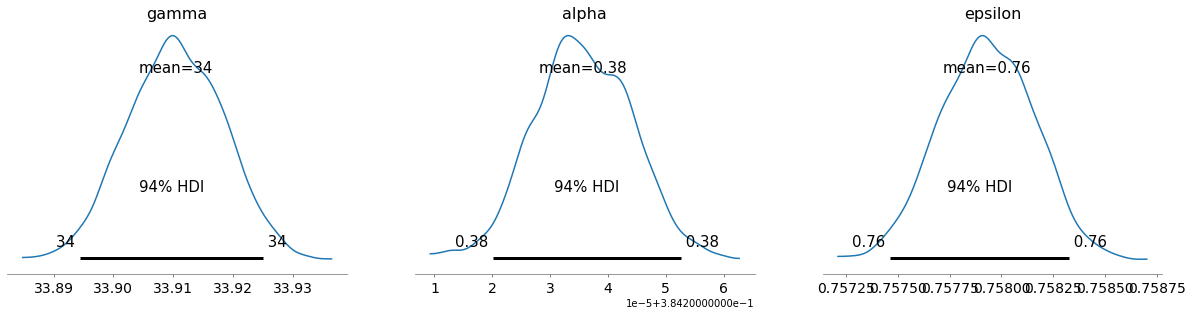

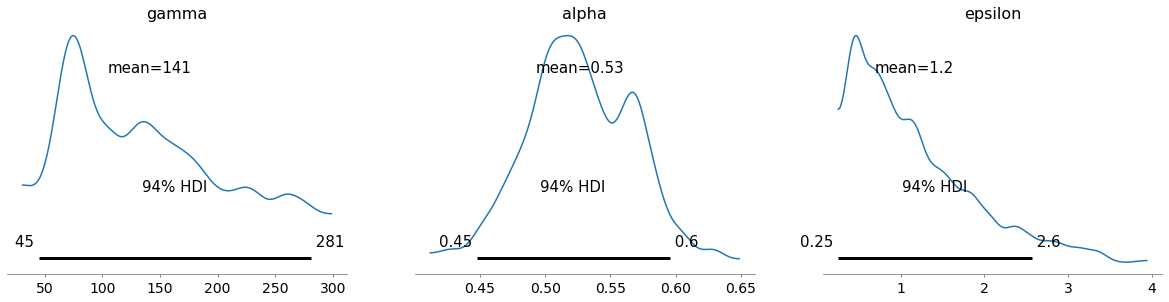

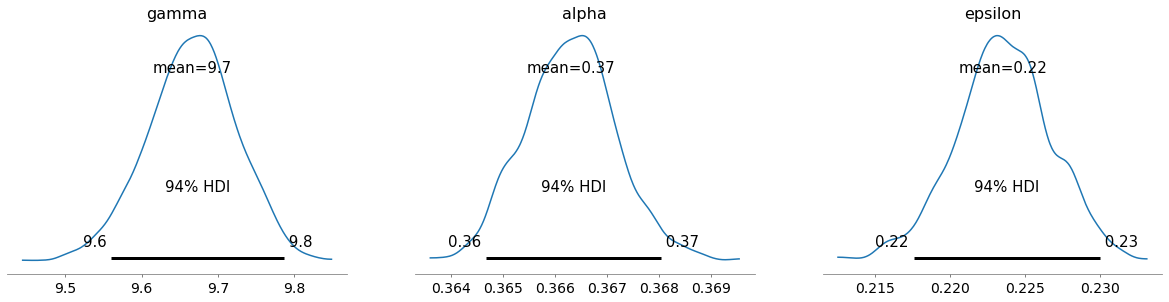

In [11]:
for mode, aa in analysis.items():
    print(mode)
    aa.plot_posterior()

In [7]:
# epsilon inside
for mode, res in results.items():
    print(mode)
    display(res.statistics(weight=True).query('dataset=="%s"' % DATASET))

g


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.452728,16614.759322,2901.090881,0.298244,-0.07881,-0.029294,0.070308
5,Quality,velocity,0.809530,38.222427,25.999825,0.070978,-0.07881,-0.029294,0.070308


velocity


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.506465,15777.981720,2580.637039,0.306283,-0.131878,0.059678,-0.00685
5,Quality,velocity,0.885284,29.663155,21.947751,0.072566,-0.131878,0.059678,-0.00685


In [18]:
# no epsilon
for mode, res in results.items():
    print(mode)
    display(res.statistics(weight=True).query('dataset=="%s"' % DATASET))

g


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.458011,16534.375901,2881.716877,0.301822,-0.080772,-0.030096,0.072818
5,Quality,velocity,0.801288,39.040642,26.227463,0.071860,-0.080772,-0.030096,0.072818


velocity


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.571693,14698.411063,2326.007769,0.312647,-0.149883,0.076382,-0.010497
5,Quality,velocity,0.887147,29.421339,21.784515,0.074044,-0.149883,0.076382,-0.010497


In [12]:
# epsilon outside
for mode, res in results.items():
    print(mode)
    display(res.statistics(weight=True).query('dataset=="%s"' % DATASET))

g


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.452728,16614.759322,2901.090881,0.298244,-0.07881,-0.029294,0.070308
5,Quality,velocity,0.809530,38.222427,25.999825,0.070978,-0.07881,-0.029294,0.070308


log_g


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.020769,22224.666228,5518.790979,0.839121,0.07343,-0.356252,0.284472
5,Quality,velocity,0.353440,70.422224,48.802264,0.203536,0.07343,-0.356252,0.284472


velocity


,dataset,observation,r2,RMSE,MAE,MLSE,Res(Log y),Res(Log mhi_R),Res(Log nulled)
4,Quality,little g,0.506465,15777.981720,2580.637039,0.306283,-0.131878,0.059678,-0.00685
5,Quality,velocity,0.885284,29.663155,21.947751,0.072566,-0.131878,0.059678,-0.00685


g
log_g
velocity


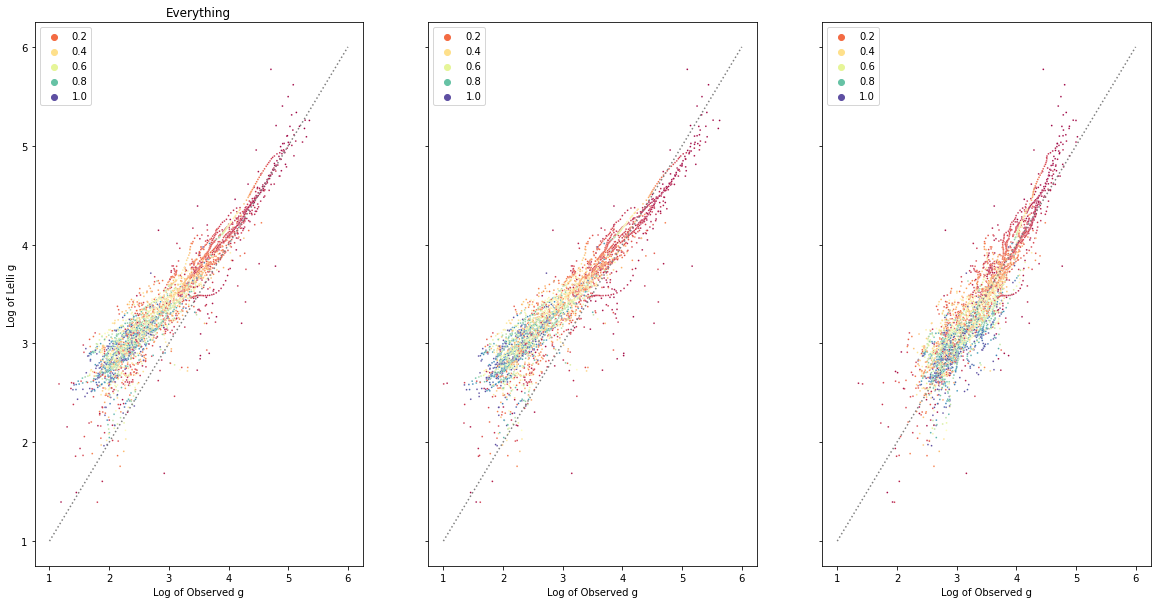

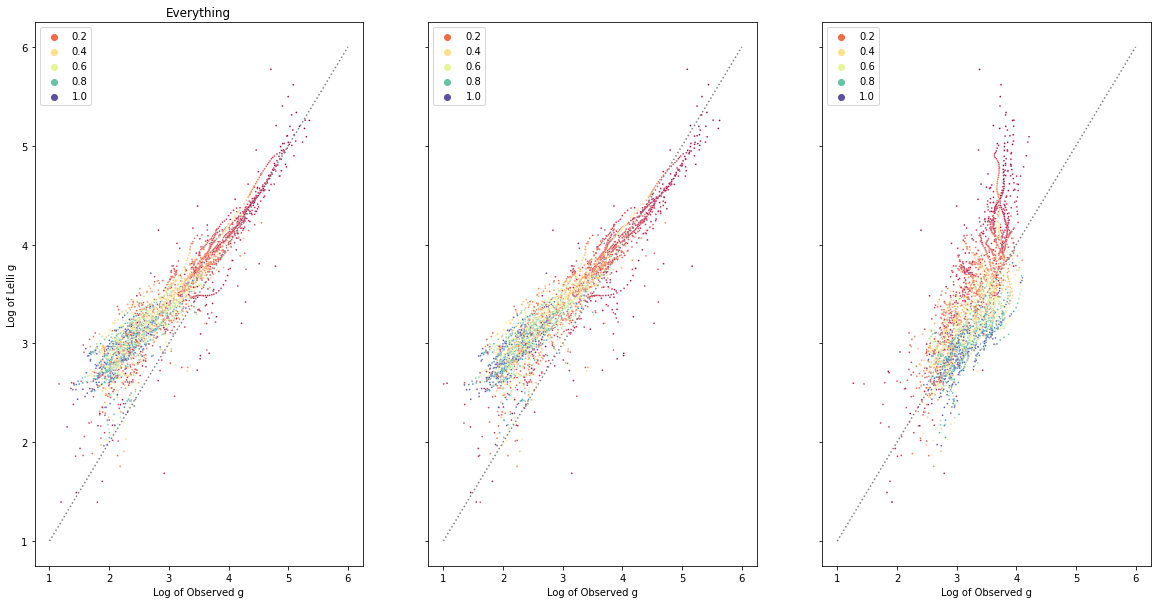

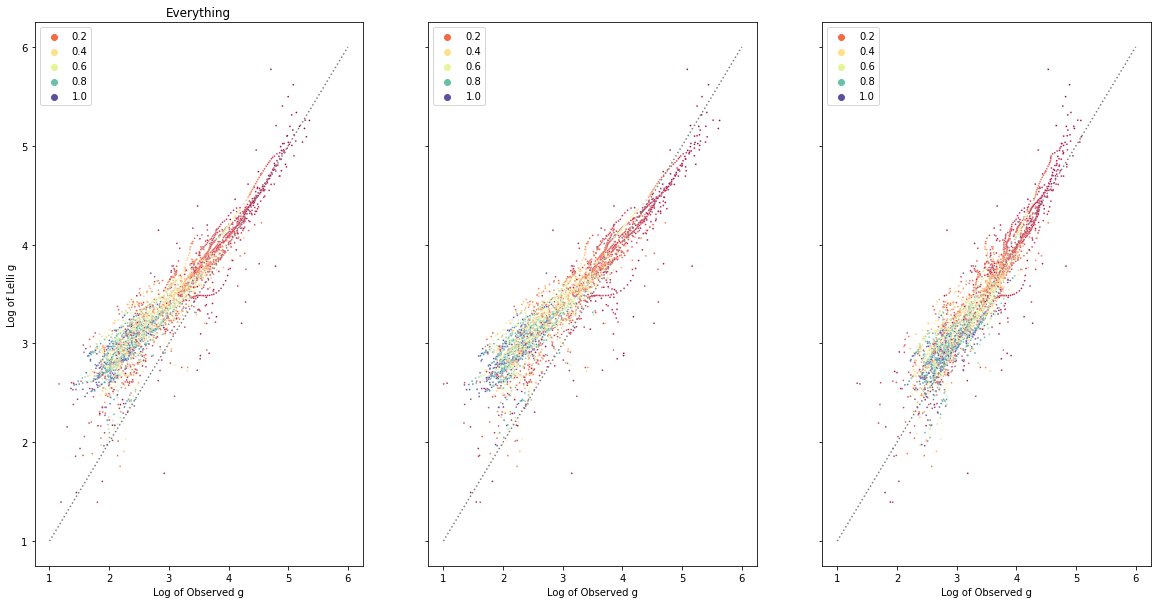

In [13]:
for mode, res in results.items():
    print(mode)
    res.plot_rar(kind=0, query_key='Everything')

g
log_g
velocity


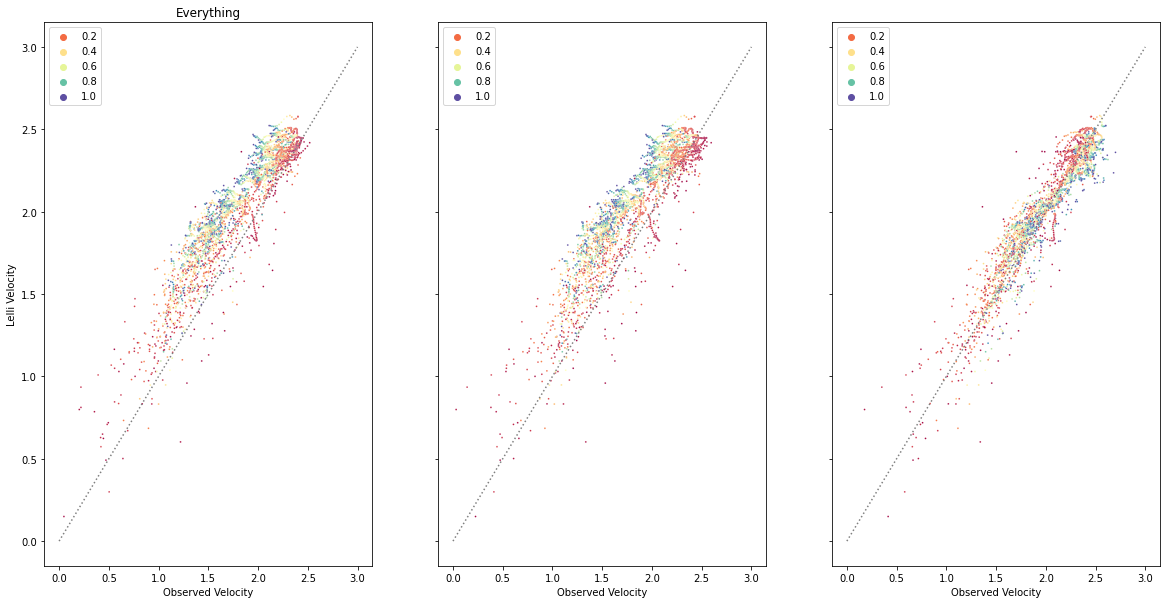

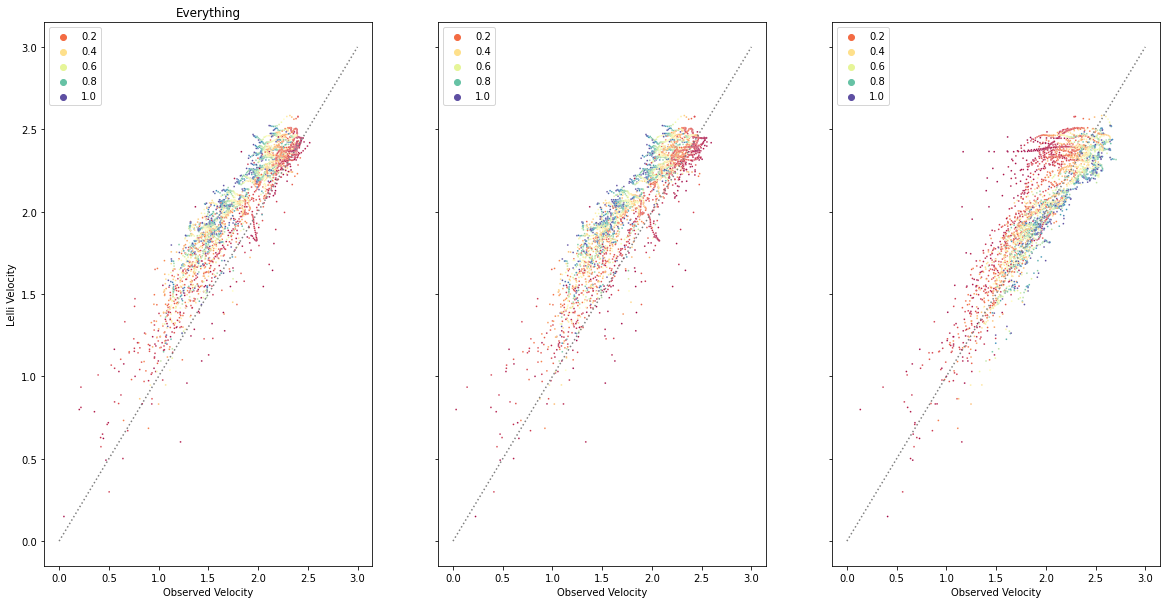

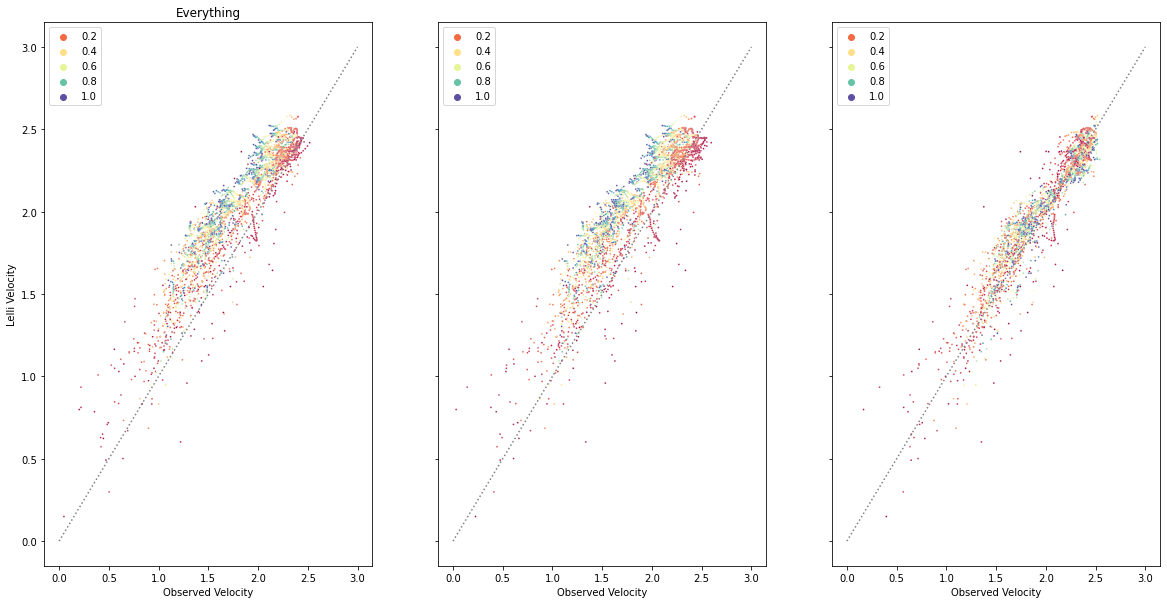

In [15]:
for mode, res in results.items():
    print(mode)
    res.plot_rar(kind=0, query_key='Everything', velocity=True, line=[0,3])

In [2]:
from references.sparc import adjustment_df
adjs = adjustment_df()

In [61]:
adjs = adjs[adjs['Galaxy'].isin(mcmc_adjs['Galaxy'])]
adjs = pd.concat([adjs,mcmc_adjs], ignore_index=True)

In [11]:
def plot_comparison(dfs, what_sources, compare, to_source='SPARC', sort=None, x_sort='Galaxy'):
    fig, axes = plt.subplots(3, 1, figsize=(20,10))
    
    # sort correctly
    to_df = dfs[dfs['Source']==to_source].sort_values(compare)
    indx = to_df.set_index(x_sort)
    indx['sort'] = np.arange(len(indx))
    
    for i, what_source in enumerate(what_sources):
        what_df = dfs[dfs['Source']==what_source]
        
        # 1. Absolutes
        ax = axes[0]
        
        # continue sort for both what's
        what_df = what_df.join(indx[['sort']], on=x_sort).sort_values('sort')
        
        # only plot reference once
        if i == 0:
            tx, ty, te = to_df[x_sort], to_df[compare], to_df["e_%s" % compare]
            ax.fill_between(tx, ty-2*te, ty+2*te, color='whitesmoke')
            ax.fill_between(tx, ty-te, ty+te, color='lightgrey')
            sns.lineplot(x=tx, y=ty, label=to_source, color='grey', ax=ax)
            sns.scatterplot(x=tx, y=ty, color='grey', ax=ax)
        
        color = ['teal', 'orange'][i]
        wx, wy, we = what_df[x_sort], what_df[compare], what_df["e_%s" % compare]    
        g = sns.scatterplot(data=what_df, x=wx, y=compare, label=what_source, ax=ax, color=color)
        g.errorbar(wx, wy, yerr=we, ecolor=color, fmt='.k', color=color)
        
        ax.set(xticklabels=[])
        
        # 2. Ratios
        ax = axes[1]
        yy = np.array(wy)/np.array(ty)
        if i == 0:
            ax.fill_between(tx, (ty-2*te)/ty, (ty+2*te)/ty, color='whitesmoke')
            ax.fill_between(tx, (ty-te)/ty, (ty+te)/ty, color='lightgrey')
        sns.scatterplot(x=tx, y=yy, ax=ax, color=color)
        ax.set(xticklabels=[])
        
        # 3. Histogram
        ax = axes[2]
        sns.histplot(yy, ax=ax, color=color)

